# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp and John Townend at [Victoria University of Wellington---Te Herenga Waka](https://www.wgtn.ac.nz) for use by students entering the postgraduate programme in Earth Science.

We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2022, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451/2022/offering?crn=32176). Space and pandemic alert levels permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; GNSS data |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with PyGMT | Earthquake catalogue |
| **[4B](ESCI451_Module_4B.ipynb)** | **Gridded data and vectors** | **Ashfall data and GNSS** |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# Mapping Part 2: Plotting gridded data

We have already done some work with gridded data, probably without even realising it! The topography that we were plotting in the last lab is a grid of elevations that we then plotted on our maps.  Lots of spatial data in Earth Sciences are best resolved on a grid, so in this lab we are going to spend some time playing around with plotting some cool gridded data.

First up let's import PyGMT and some other stuff

In [1]:
import pygmt
import pandas as pd

We are going to play around with some model output Simon Barker and colleagues worked up in their [2018 paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GC008152) on modeling ash dispersal from future eruptions of Taupō supervolcano.

All the outputs from their models are included in an online repository, as any good, modern paper should! I have taken the liberty of including one model output in the data directory and we will start by playing with that, but you should explore the data repository and get other model outputs if you want.

The output of the model is ash thickness, and is modeled dependent on a few things, including wind direction.

Let's start by reading the data. The data is given in ESRI-ASCII format, which is used in GIS programmes like Arc. We've provided a function in `helpers` to convert this into a Pandas dataframe:

In [2]:
from helpers.asc_to_df import transform_asc_to_df

datafile = "data/DepositFile_ESRI_ASCII.txt"
df = transform_asc_to_df(datafile)
df.rename(columns={'variable': 'thickness'}, inplace=True)

Now let's draw a map and some contours of ash thickness. For the contouring we use the aptly named [`contour`](https://www.pygmt.org/latest/api/generated/pygmt.Figure.contour.html) method:

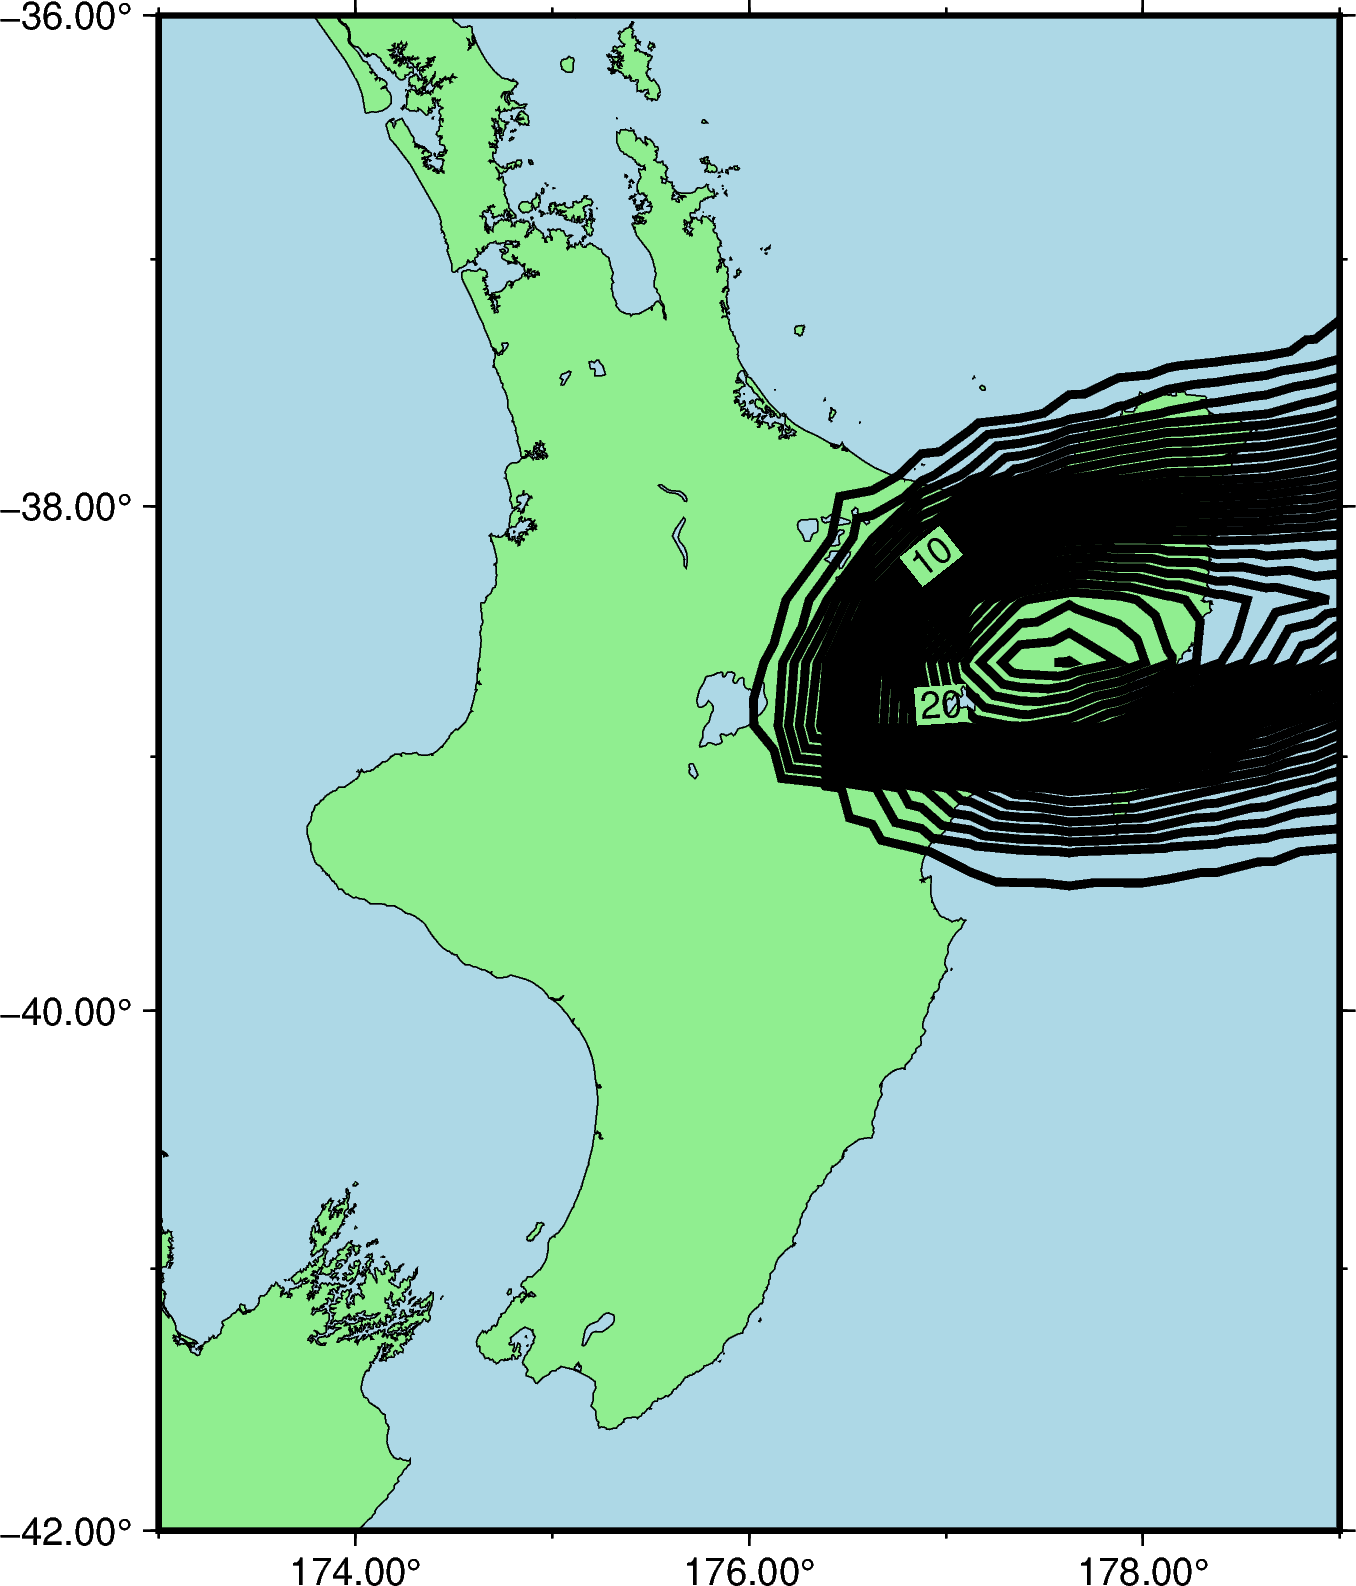

In [3]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE='plain', FORMAT_GEO_MAP='ddd.xx')
fig.coast(region=[173, 179, -42, -36],
          shorelines=True,
          land='lightgreen',
          water='lightblue',
          projection='M10c',
          frame=['WSne', 'xa2f1', 'ya2f1'])

fig.contour(x=df['longitude'],
            y=df['latitude'],
            z=df['thickness'],
            levels=1,  # draw a contour every 1mm thickness
            annotation=10,  # annotate every 10mm
            pen='2p')

fig.show()

That must have been a strong Westerly. Poor Gisbourne...

There are really too many contours drawn there and it looks very messy. Let's tell PyGMT exactly which contours to plot. To do this we need to give the `levels` paramater a comma-seperated string of the contours we want. This isn't very pythonic, but hopefully this is improved in future versions.

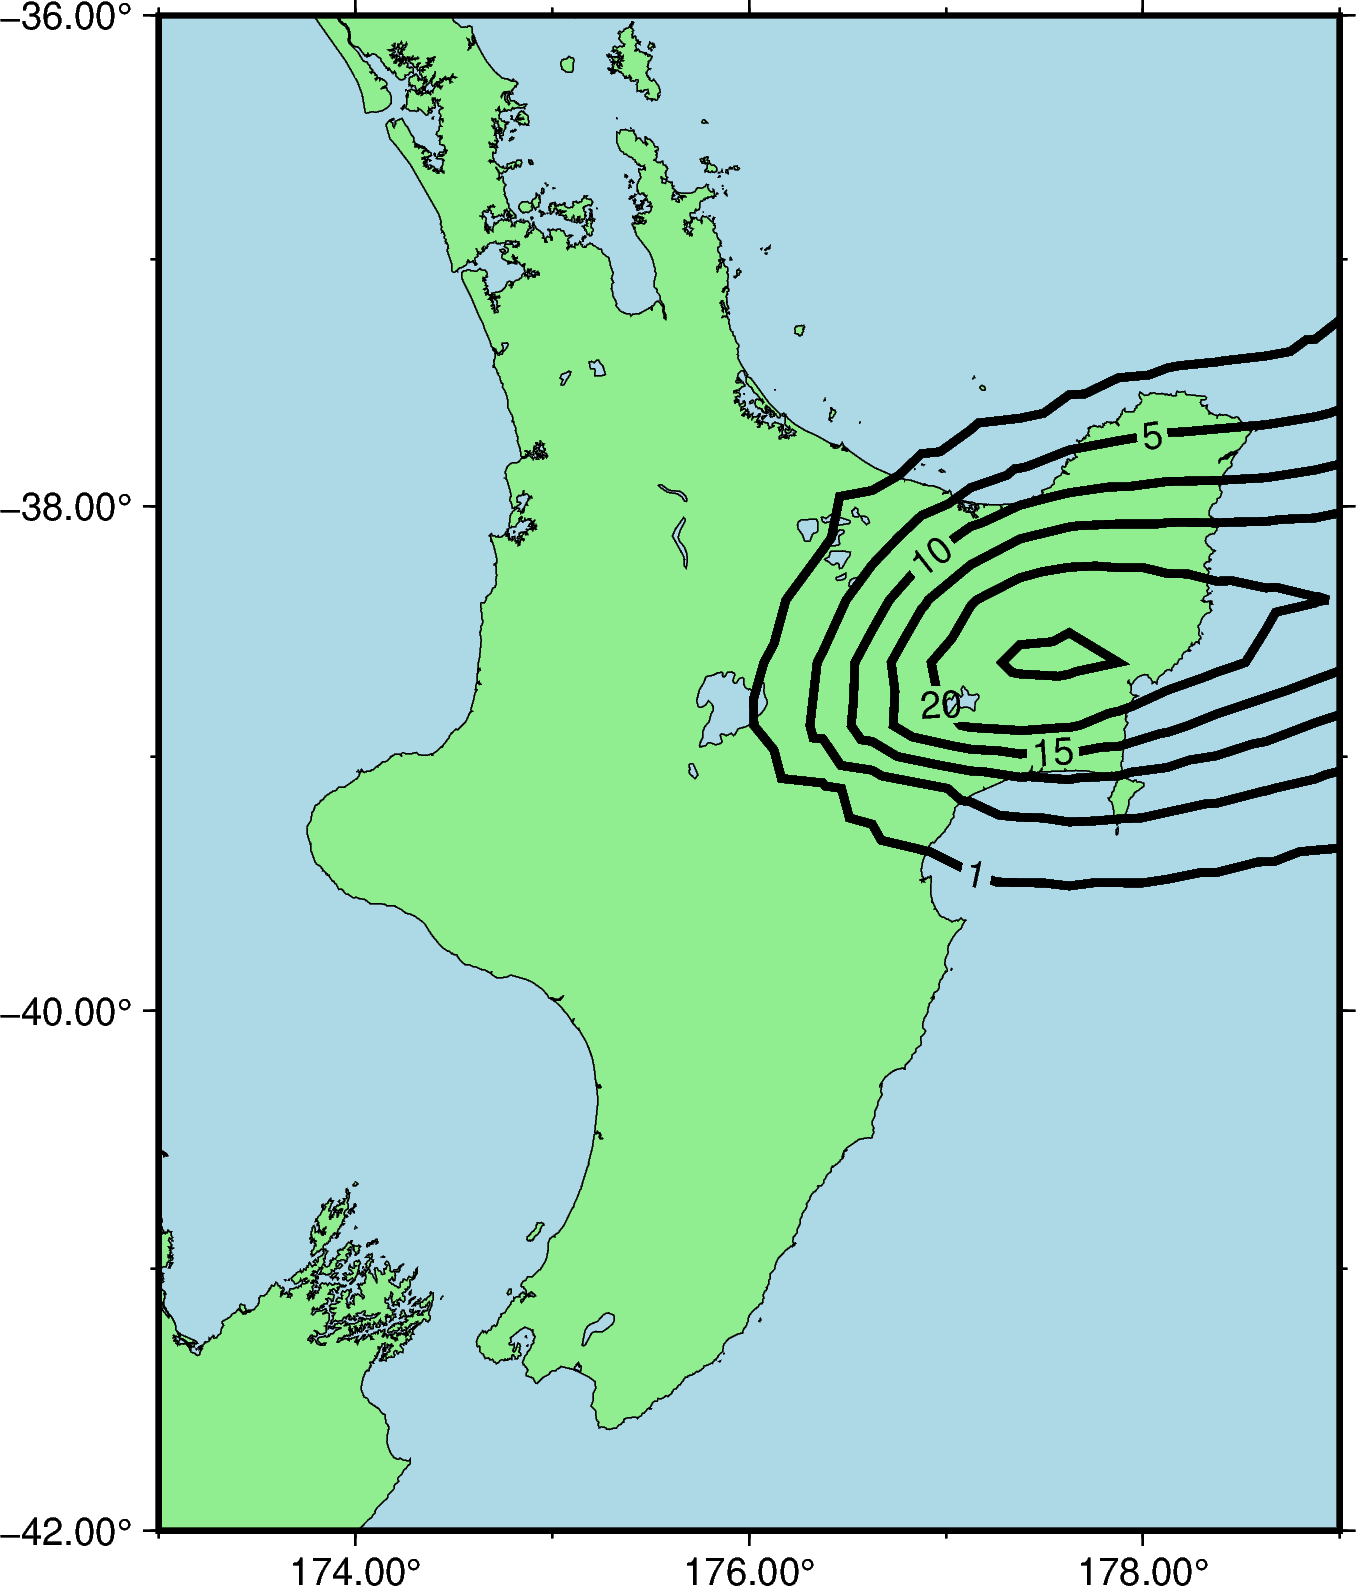

In [4]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE='plain', FORMAT_GEO_MAP='ddd.xx')
fig.coast(region=[173, 179, -42, -36],
          shorelines=True,
          land='lightgreen',
          water='lightblue',
          projection='M10c',
          frame=['WSne', 'xa2f1', 'ya2f1'])

fig.contour(x=df['longitude'],
            y=df['latitude'],
            z=df['thickness'],
            levels='1,5,10,15,20,25,30',  # The non-pythonic comma separated string
            # The annotations we want to add to the contours.
            annotation='1,5,10,15,20,25,30',
            pen='2p')

fig.show()

That's pretty easy and very handy for many earth science datasets. You can do something very similar with topography using the [`grdcontour`](https://www.pygmt.org/latest/api/generated/pygmt.Figure.grdcontour.html) method.

Now, go and download a different model run from Simon's [repository](https://www.sciencebase.gov/catalog/item/5cdd9ed7e4b029273746367a) and plot it up:

In [5]:
# Your answer here

# Plotting Vectors

Another common observation we deal with in Earth Science is vectors. PyGMT can handle these really nicely.

For this exercise we're going to go down to Kaikōura and will begin by plotting an arbitrary vector with the [`velo`](https://www.pygmt.org/latest/api/generated/pygmt.Figure.velo.html) method. We first have to out our data into a `dataframe` and then we plot it:

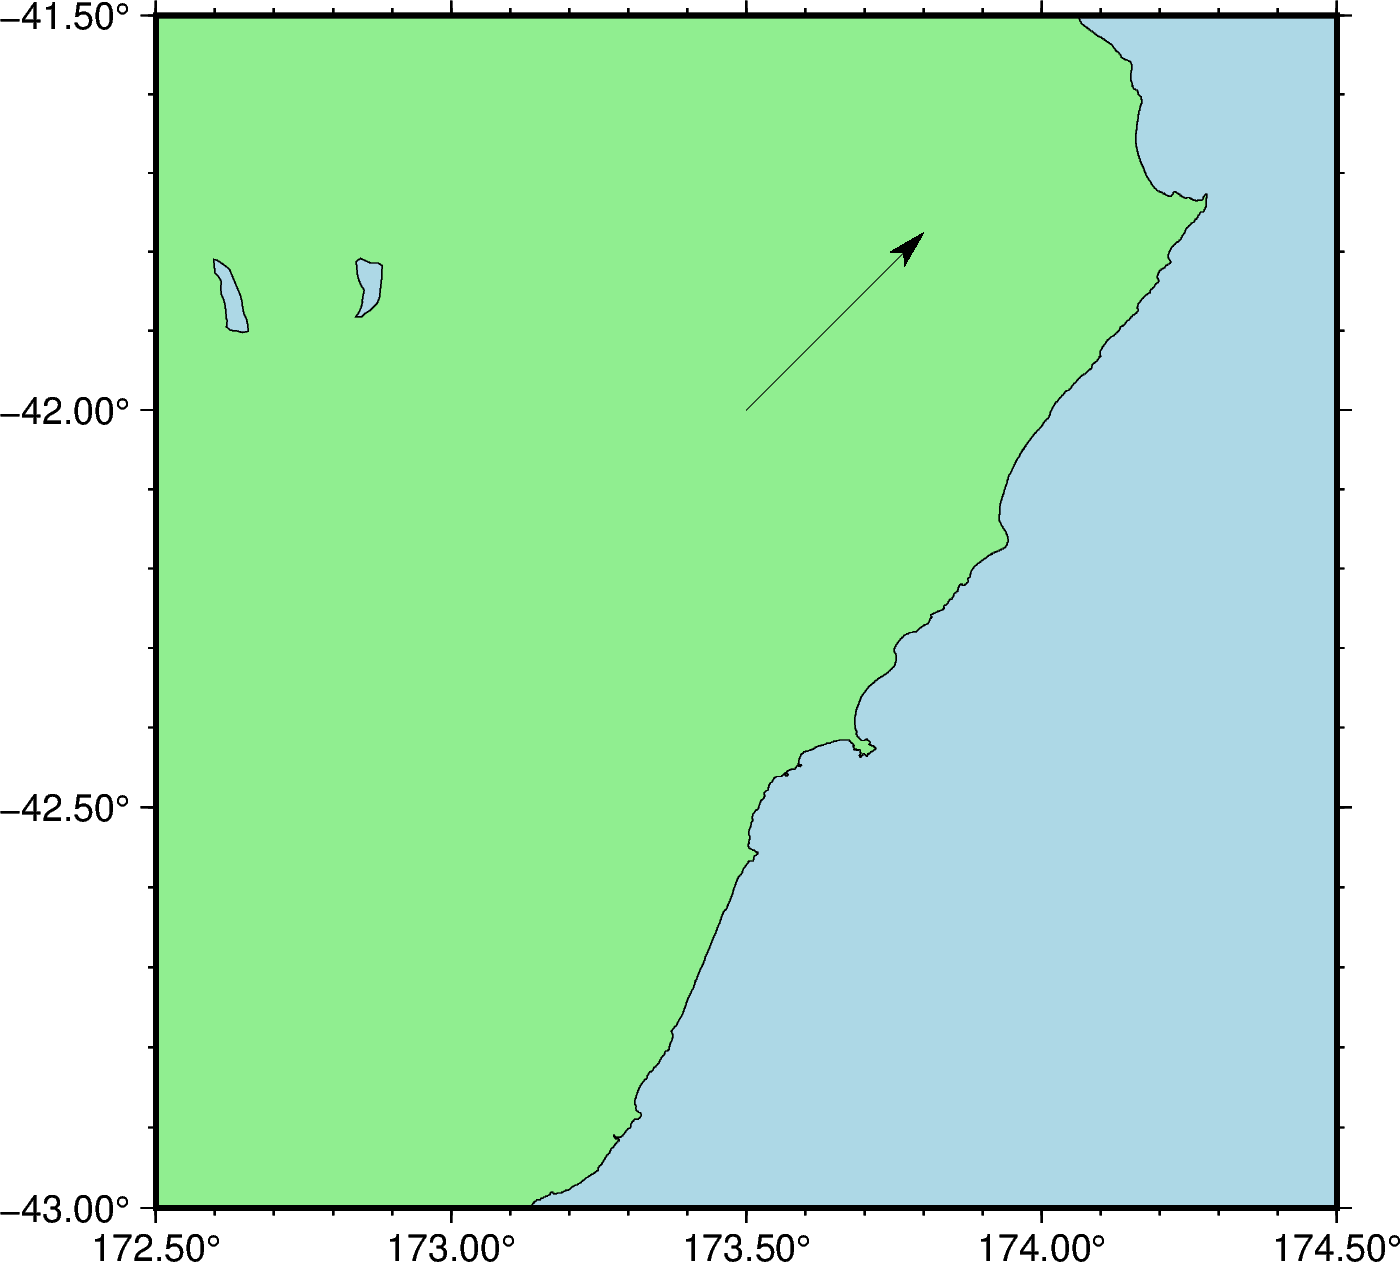

In [6]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE='plain', FORMAT_GEO_MAP='ddd.xx')
fig.coast(region=[172.5, 174.5, -43, -41.5],
          shorelines=True,
          land='lightgreen',
          water='lightblue',
          projection='M10c',
          frame=['WSne', 'xa0.5f0.1', 'ya0.5f0.1'])

# Make a dataframe to store our data
df = pd.DataFrame(data={
    "x": [173.5],
    "y": [-42],
    "east_velocity": [3],
    "north_velocity": [3],
})

fig.velo(data=df,
         pen='1p,black',  # vector line
         color='black',  # arrow head
         spec='e0.5/0.5',  # this is telling it to plot a vector with a scale of 0.5 cm for each unit
         )

fig.show()

Ok great, but that vector doesn't mean anything. Let's do something more interesting.

Let's begin by importing some GNSS data using the function from our previous notebook that is also included in the helpers module:

In [7]:
from helpers.get_data import get_gnss_for_station
import datetime as dt

Let's use that to download some data from a Kaikōura GNSS station, remember you can see the map of GNSS stations [here](https://www.geonet.org.nz/data/gnss/map):

In [8]:
GNSS_data = pd.DataFrame(get_gnss_for_station(
    'KAIK', starttime=dt.datetime(2010, 1, 1), endtime=dt.datetime(2020, 1, 1)))

Nice, now let's have a look at that GNSS data either side of the [Kaikōura earthquake](https://www.geonet.org.nz/earthquake/2016p858000). Remember this earthquake happened at 11:02:56 on 2016-11-13 (UTC time):

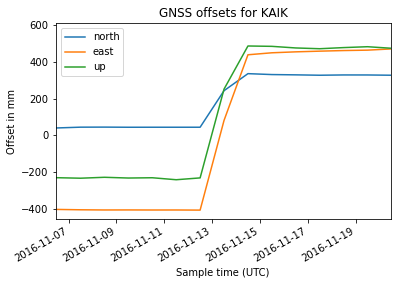

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for component in ["north", "east", "up"]:
    ax.plot(GNSS_data["time"], GNSS_data[component],
            label=component)

ax.set_xlim(
    dt.datetime(2016, 11, 6, 11, 2, 56),
    dt.datetime(2016, 11, 20, 11, 2, 56))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for KAIK")
ax.legend()
fig.autofmt_xdate()  # Simple fix for overlapping dates on x-axis

plt.show()

That's quite an offset! We could calculate a vector from that displacement

Let's first cut our dataset down to the two week period we're interested in. We can do this by defining a filter and using the [`loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method on our `pandas.DataFrame`:

In [10]:
date_filter = (GNSS_data['time'] >= '2016/11/06T11:02:56') & (
    GNSS_data['time'] <= '2016/11/20T11:02:56')

GNSS_data.loc[date_filter]

,time,north,east,up,north_error,east_error,up_error
2500,2016-11-06 11:59:00,40.21,-404.31,-231.19,2.53,2.26,8.36
2501,2016-11-07 11:59:00,44.49,-406.30,-234.00,1.46,1.40,4.77
2502,2016-11-08 11:59:00,44.82,-407.32,-228.96,1.70,1.58,5.53
2503,2016-11-09 11:59:00,44.05,-407.11,-233.01,2.12,1.93,7.12
2504,2016-11-10 11:59:00,44.19,-407.49,-231.49,1.50,1.40,4.92
2505,2016-11-11 11:59:00,44.14,-407.38,-242.30,1.82,1.69,6.08
2506,2016-11-12 11:59:00,44.17,-408.08,-232.32,1.47,1.36,4.88
2507,2016-11-13 11:59:00,243.57,81.29,252.16,12.57,19.66,38.57
2508,2016-11-14 11:59:00,336.56,439.54,487.48,3.09,2.71,10.46
2509,2016-11-15 11:59:00,331.57,450.38,485.54,2.48,2.23,8.28


You can see that we've filtered our dataframe so that we now only have the data covering that two week period. Now to calculate the displacement over this time-window we simply need to calculate the difference between the north and east components at the beginning and end of this time period. Here's an example of how to do this for the North component using the handy [`first_valid_index`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.first_valid_index.html?highlight=first_valid_index#pandas.DataFrame.first_valid_index) and [`last_valid_index`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.last_valid_index.html?highlight=last_valid_index#pandas.DataFrame.last_valid_index) methods:

In [11]:
date_filter = (GNSS_data['time'] >= '2016/11/06T11:02:56') & (
    GNSS_data['time'] <= '2016/11/20T11:02:56')

N_first_value = GNSS_data.loc[date_filter]['north'].first_valid_index()
N_last_value = GNSS_data.loc[date_filter]['north'].last_valid_index()

N_disp = N_last_value - N_first_value

print(f"The displacement if {N_disp} mm")

The displacement if 13 mm


Now here's an exercise. Calculate both the North and East displacement for this GNSS station and plot it as a vector on the map. To give you a hand I've given you some code to download the GNSS locations from GeoNet and an example of how to get the Latitude for KAIK:

In [12]:
# Downloading the GNSS locations from GeoNet's GitHub
url = (r'https://raw.githubusercontent.com/GeoNet/delta/main/network/marks.csv')
sites = pd.read_csv(url, delimiter=",")
sites.head()
sites = sites.reset_index()

site_lat = sites.loc[sites['Mark'] == 'KAIK']['Latitude']


# Your answer here

Great, now write a loop that downloads data and calculates vectors for the following nearby GNSS sites (MRBL, HANM, CMBL, WITH) and then plot them on a map.

You could also plot the Kaikōura [epicentre](https://www.geonet.org.nz/earthquake/2016p858000):

In [13]:
# Your answer here

---
## Beyond GMT

GMT makes really pretty plots but not this isn't by any means the only way to plot geospatial data. Below are a list of other projects you might want to check out:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) is the most "pythonic" map plotting library at the moment, but it can be painful with a lot of geospatial data. It is worth a look though and if you are interested we have some resources from previous years using caropty.
- [bokeh](https://bokeh.org/) is pretty cool for creating interactive plots, including [maps](https://docs.bokeh.org/en/latest/docs/user_guide/geo.html) - CJC uses this quite a bit for interogating data.
- [follium](https://github.com/python-visualization/folium) looks nice for making interactive mapping plots - possibly better than bokeh because it is more focused on mapping.

That is all for now - hopefully that has given you some idea of how you can make some fairly nice plots without too much effort.  A key idea with these notebooks is for you to **borrow some code** from them so that you do not have to re-write everything yourself.

# Fin

Great! All being well you now know a little more about programming, and Python. At the least, we hope that this course has shown you that **you can write code** - it doesn't have to be perfect, and your skills will improve with time, *but* you now have the power to make computers do a lot of your work for you! Yay!

Now you can write some code and use the legitimate excuse of every programmer (although in Python you don't have to spend time compilling, you can just run your code!):

<div>
    <img src="https://imgs.xkcd.com/comics/compiling.png"><br>
</div>